In [1]:
from __future__ import division, print_function

import lib.xmlreader as xml
import lib.utils as ut
import numpy as np

import gensim.models.word2vec
import itertools
from collections import Counter
from nltk.tokenize import word_tokenize

import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import collections
import numpy as np
import matplotlib.pyplot as plt
import operator
import os
%matplotlib inline

In [2]:
#train_docs = xml.readXML("../database/TASS/TASS2018/task1-Training.xml",[0,1,2,3])
#dev_docs   = xml.readXML("../database/TASS/TASS2018/task1-Development.xml",[0,1,2,3])
test_docs  = xml.readXML("../database/TASS/TASS2018/task1-Test.xml",[0,1,2,3])

None
None
None


UnboundLocalError: local variable 'rpolarity' referenced before assignment

In [1]:
len(test_docs)

NameError: name 'test_docs' is not defined

In [2]:
corpus = []
for doc in train_docs + dev_docs + test_docs:
    corpus.append(doc.content)

NameError: name 'train_docs' is not defined

In [131]:
len(test_docs + dev_docs + train_docs)

2928

In [132]:
train_labels = []
for doc in train_docs:
    train_labels.append(doc.polarity)
    
dev_labels  = []
for doc in dev_docs:
    dev_labels.append(doc.polarity)

In [133]:
def gensim_load_vec(path="../database/embeddings/SBW-vectors-300-min5.bin"):
    #use gensim_emb.wv.index2word if used this way to load vectors
    #gensim_emb = gensim.models.word2vec.Word2Vec.load(path)
    gensim_emb =  gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    vocab = gensim_emb.index2word
    vec = gensim_emb.syn0
    shape = gensim_emb.syn0.shape
    return gensim_emb, vec, shape, vocab

In [6]:
gensim_emb, vec, shape, vocab = gensim_load_vec()

/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  
/home/jose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  import sys


In [134]:
counter = CountVectorizer(tokenizer=ut.tokenizer)

In [135]:
X = counter.fit_transform(corpus)
print(X.shape)

(2928, 8706)


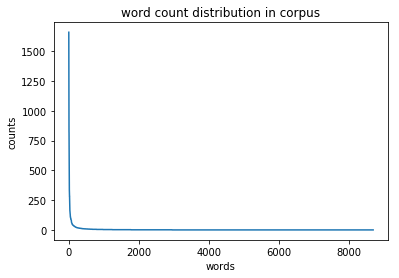

In [136]:
counts = np.sum(X, axis=0).tolist()
counts = sorted(counts[0], reverse=True)
plt.plot(np.arange(len(counts)), counts)
plt.title("word count distribution in corpus")
plt.ylabel("counts")
plt.xlabel("words")
acc = []

In [137]:
# VOCAB_SIZE = 3000
VOCAB_SIZE = X.shape[1]
# counter = CountVectorizer(strip_accents="unicode", max_features=VOCAB_SIZE)
# counter = CountVectorizer(max_features=VOCAB_SIZE, tokenizer=ut.tokenizer)

caption_texts = corpus
Xc = counter.fit_transform(caption_texts).todense().astype("float")
print(Xc.shape)

(2928, 8706)


In [138]:
sent_lens = np.sum(Xc, axis=1).astype("float")
sent_lens[sent_lens == 0] = 1e-14
print(sent_lens.shape)

(2928, 1)


In [139]:
E = np.zeros((VOCAB_SIZE, 300))
for word in list(counter.vocabulary_.keys()):
    try:
        i = counter.vocabulary_[word]
        E[i] = gensim_emb[word]
    except KeyError:
        pass
print(E.shape)

(8706, 300)


In [140]:
Xb = np.divide(np.dot(Xc, E), sent_lens)
print(Xb.shape)

(2928, 300)


In [141]:
Xtrain, Xdev = Xb[0:len(train_docs)], Xb[len(train_docs):len(train_docs)+len(dev_docs)]
ytrain, ydev = np.array(train_labels), np.array(dev_labels)
print(Xtrain.shape, ytrain.shape, Xdev.shape, ydev.shape)

(1000, 300) (1000,) (500, 300) (500,)


In [142]:
import tensorflow as tf
import keras 

from keras.utils import to_categorical
from keras import backend as K

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D

from keras.callbacks import ModelCheckpoint

print(K.tensorflow_backend._get_available_gpus())


config = tf.ConfigProto(intra_op_parallelism_threads=4, \
                        inter_op_parallelism_threads=4, \
                        allow_soft_placement=True,\
                        device_count = {'CPU' : 1, 'GPU' : 0})

sess = tf.Session(config=config)
K.set_session(sess)
    
seed = 7

['/job:localhost/replica:0/task:0/device:GPU:0']


In [170]:
tweet_encoder   = Input(shape=(300,), dtype='float32')

merged = Dense(256)(tweet_encoder)
merged = Dropout(0.5)(merged)

merged = Dense(128)(tweet_encoder)
merged = Dropout(0.5)(merged)

merged = Dense(64)(tweet_encoder)
merged = Dropout(0.2)(merged)

merged = Dense(4)(merged)
output = Activation('softmax')(merged)
model  = Model(inputs=[tweet_encoder], outputs=[output])

model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 300)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 64)                19264     
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 260       
_________________________________________________________________
activation_13 (Activation)   (None, 4)                 0         
Total params: 19,524
Trainable params: 19,524
Non-trainable params: 0
_________________________________________________________________


In [171]:
filepath="model/CNN_best_weights_SIF.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(Xtrain, to_categorical(ytrain), batch_size=64, epochs=50,
                     validation_data=(Xdev, to_categorical(ydev)), callbacks = [checkpoint], verbose=1)

Train on 1000 samples, validate on 500 samples
Epoch 1/50
1000/1000 [==============================] - 0s 469us/step - loss: 1.3612 - acc: 0.3520 - val_loss: 1.2688 - val_acc: 0.4760

Epoch 00001: val_acc improved from -inf to 0.47600, saving model to model/CNN_best_weights_SIF.01-0.4760.hdf5
Epoch 2/50
1000/1000 [==============================] - 0s 22us/step - loss: 1.3273 - acc: 0.3740 - val_loss: 1.2665 - val_acc: 0.4820

Epoch 00002: val_acc improved from 0.47600 to 0.48200, saving model to model/CNN_best_weights_SIF.02-0.4820.hdf5
Epoch 3/50
1000/1000 [==============================] - 0s 29us/step - loss: 1.3137 - acc: 0.3740 - val_loss: 1.2498 - val_acc: 0.4880

Epoch 00003: val_acc improved from 0.48200 to 0.48800, saving model to model/CNN_best_weights_SIF.03-0.4880.hdf5
Epoch 4/50
1000/1000 [==============================] - 0s 27us/step - loss: 1.2935 - acc: 0.4260 - val_loss: 1.2359 - val_acc: 0.4820

Epoch 00004: val_acc did not improve from 0.48800
Epoch 5/50
1000/1000 [

In [160]:
Xtest = Xb[-len(test_docs):]

In [161]:
from keras.models import load_model

best_model = load_model('model/CNN_best_weights_SIF.22-0.5140.hdf5')

In [162]:
ytest_result = best_model.predict(Xtest)

In [163]:
ytest_result.shape

(1428, 4)

In [164]:
test_values = np.argmax(ytest_result, axis=1)

In [165]:
def getLabel(num):
    if num == 0:
        return 'N'
    elif num == 1:
        return 'P'
    elif num == 2:
        return 'NEU'
    elif num == 3:
        return 'NONE'

In [2]:
import xml.etree.ElementTree as ET

def putTestValue(xmlFIle):
    tree = ET.parse(xmlFIle)
    root = tree.getroot()

    tweets = []
    file = open("output.txt","w") 
    for i,tweet in enumerate(root.iter('tweet')):
        #content = tweet.find('content').text
        #sentiment = tweet.find('sentiment')
        
        val = getLabel(test_values[i])
        #sentiment.find('polarity').find('value').text= val
        #polarity = sentiment.find('polarity').find('value').text
        ID = tweet.find('tweetid').text
        file.write(ID + "\t" + val + "\n")
        #print(polarity)
    
    file.close() 
    #mydata = ET.ElementTree(root)  
    #myfile = open("output.xml", "w")  
    #mydata.write("output.xml")  
    #return tweets

In [3]:

putTestValue("../database/TASS/TASS2018/intertass-PE-test.xml")

FileNotFoundError: [Errno 2] No such file or directory: '../database/TASS/TASS2018/intertass-PE-test.xml'

In [6]:
tree = ET.parse("../database/TASS/TASS2018/task1-Test.xml")
root = tree.getroot()

In [13]:
tweet = next(root.iter('tweet'))
sentiment = tweet.find('sentiment')
type(sentiment.find('polarity').find('value').text)

NoneType

In [15]:
sentiment.find('polarity').find('value').text == 

False

In [12]:
None in [0,1,2]

False

In [6]:
None.__eq__('N+')

NotImplemented